In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *
import random
import models

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# general parameters
dataset_name = "BA_Grid"

model_type = BA_Shapes_GCN
load_pretrained = True

# hyperparameters
k = 15

# other parameters
train_test_split = 0.8
num_hidden_units = 20
num_classes = 2

epochs = 2500
lr = 0.001

In [3]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split)
model = model_type(data["x"].shape[1], num_hidden_units, num_classes, "BA-Grid")

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
        
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train(model, data, epochs, lr, paths['base'])

Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2
Loading pretrained model...


In [4]:
x = data["x"]
edges = data["edges"]
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
print(test(model, x, y, edges, train_mask))
print(test(model, x, y, edges, test_mask))

torch.Size([1020, 20])
torch.Size([1020, 20])
0.9987730061349693
torch.Size([1020, 20])
torch.Size([1020, 20])
0.9951219512195122


In [5]:
key_list = activation_list.keys()

activation_list.pop('conv0')
activation_list.pop('conv1')
activation_list.pop('conv2')
activation_list.pop('linear')

for layer_num, key in enumerate(activation_list):
    print(key)
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    print(activation.shape)

conv3
(1020, 20)


# Dimensionality Reduction

### TSNE

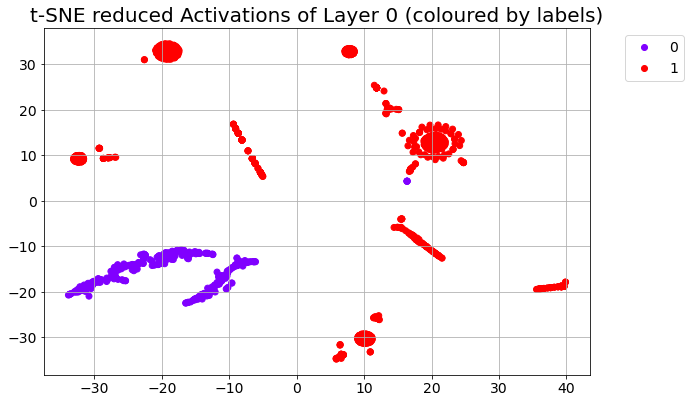

In [6]:
# TSNE conversion
tsne_models = []
tsne_data = []

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

### PCA

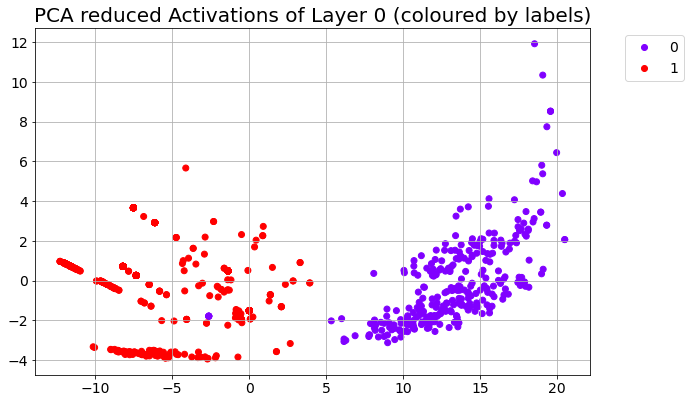

In [7]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

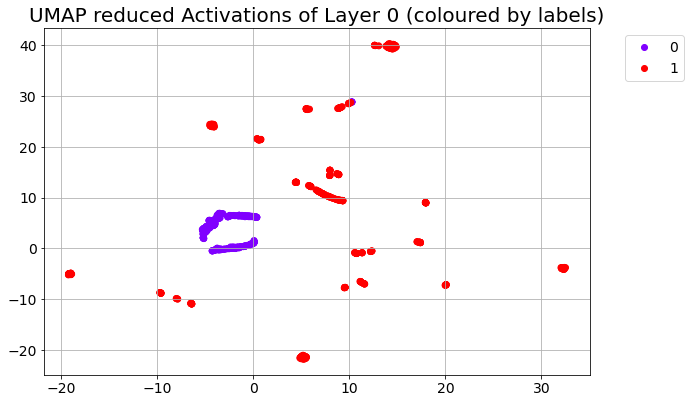

In [8]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    plot_activation_space(d, labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

In [9]:
num_nodes_view = 5
num_expansions = 5
edges = data['edge_list'].numpy()

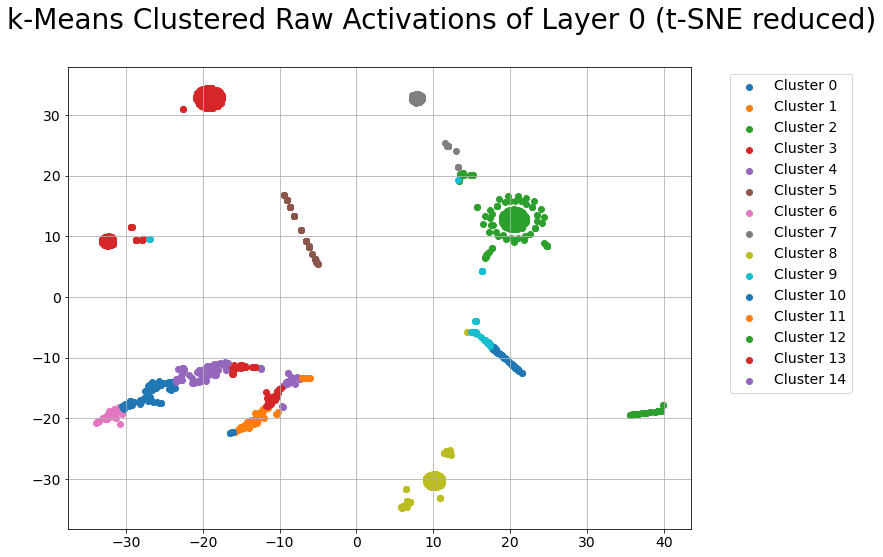

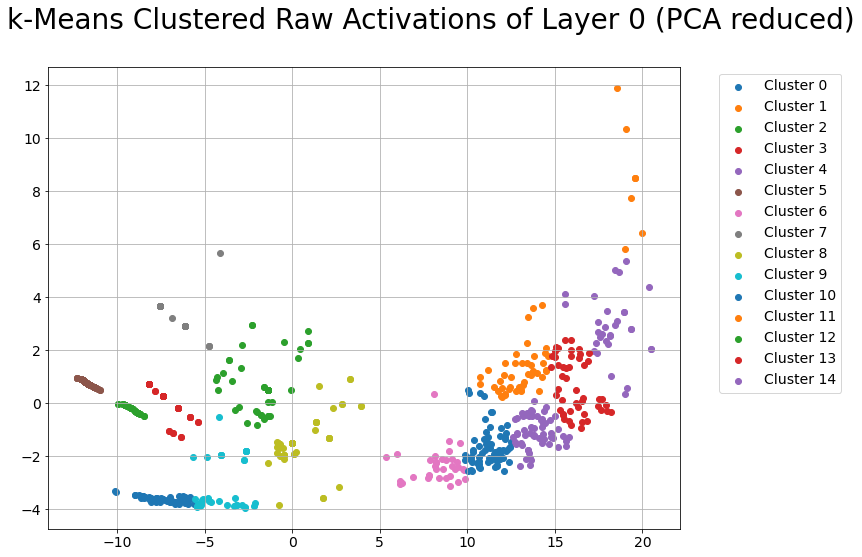

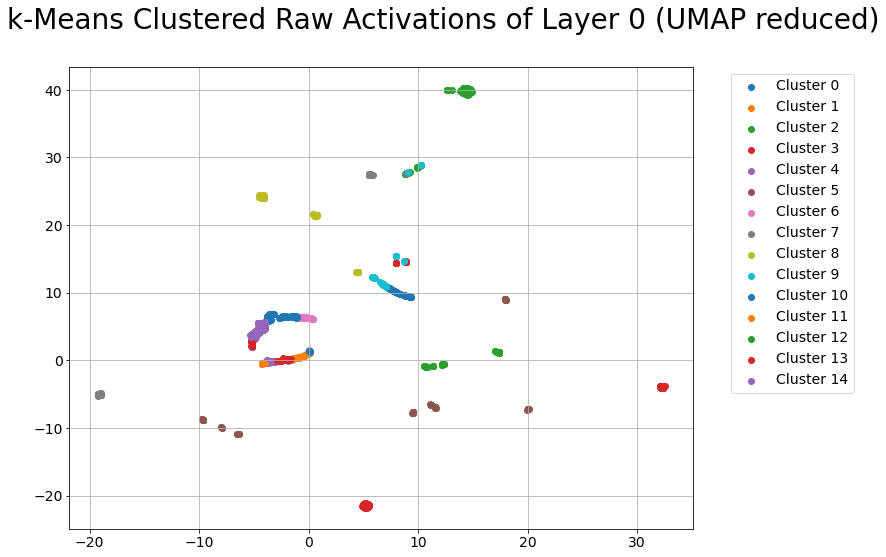

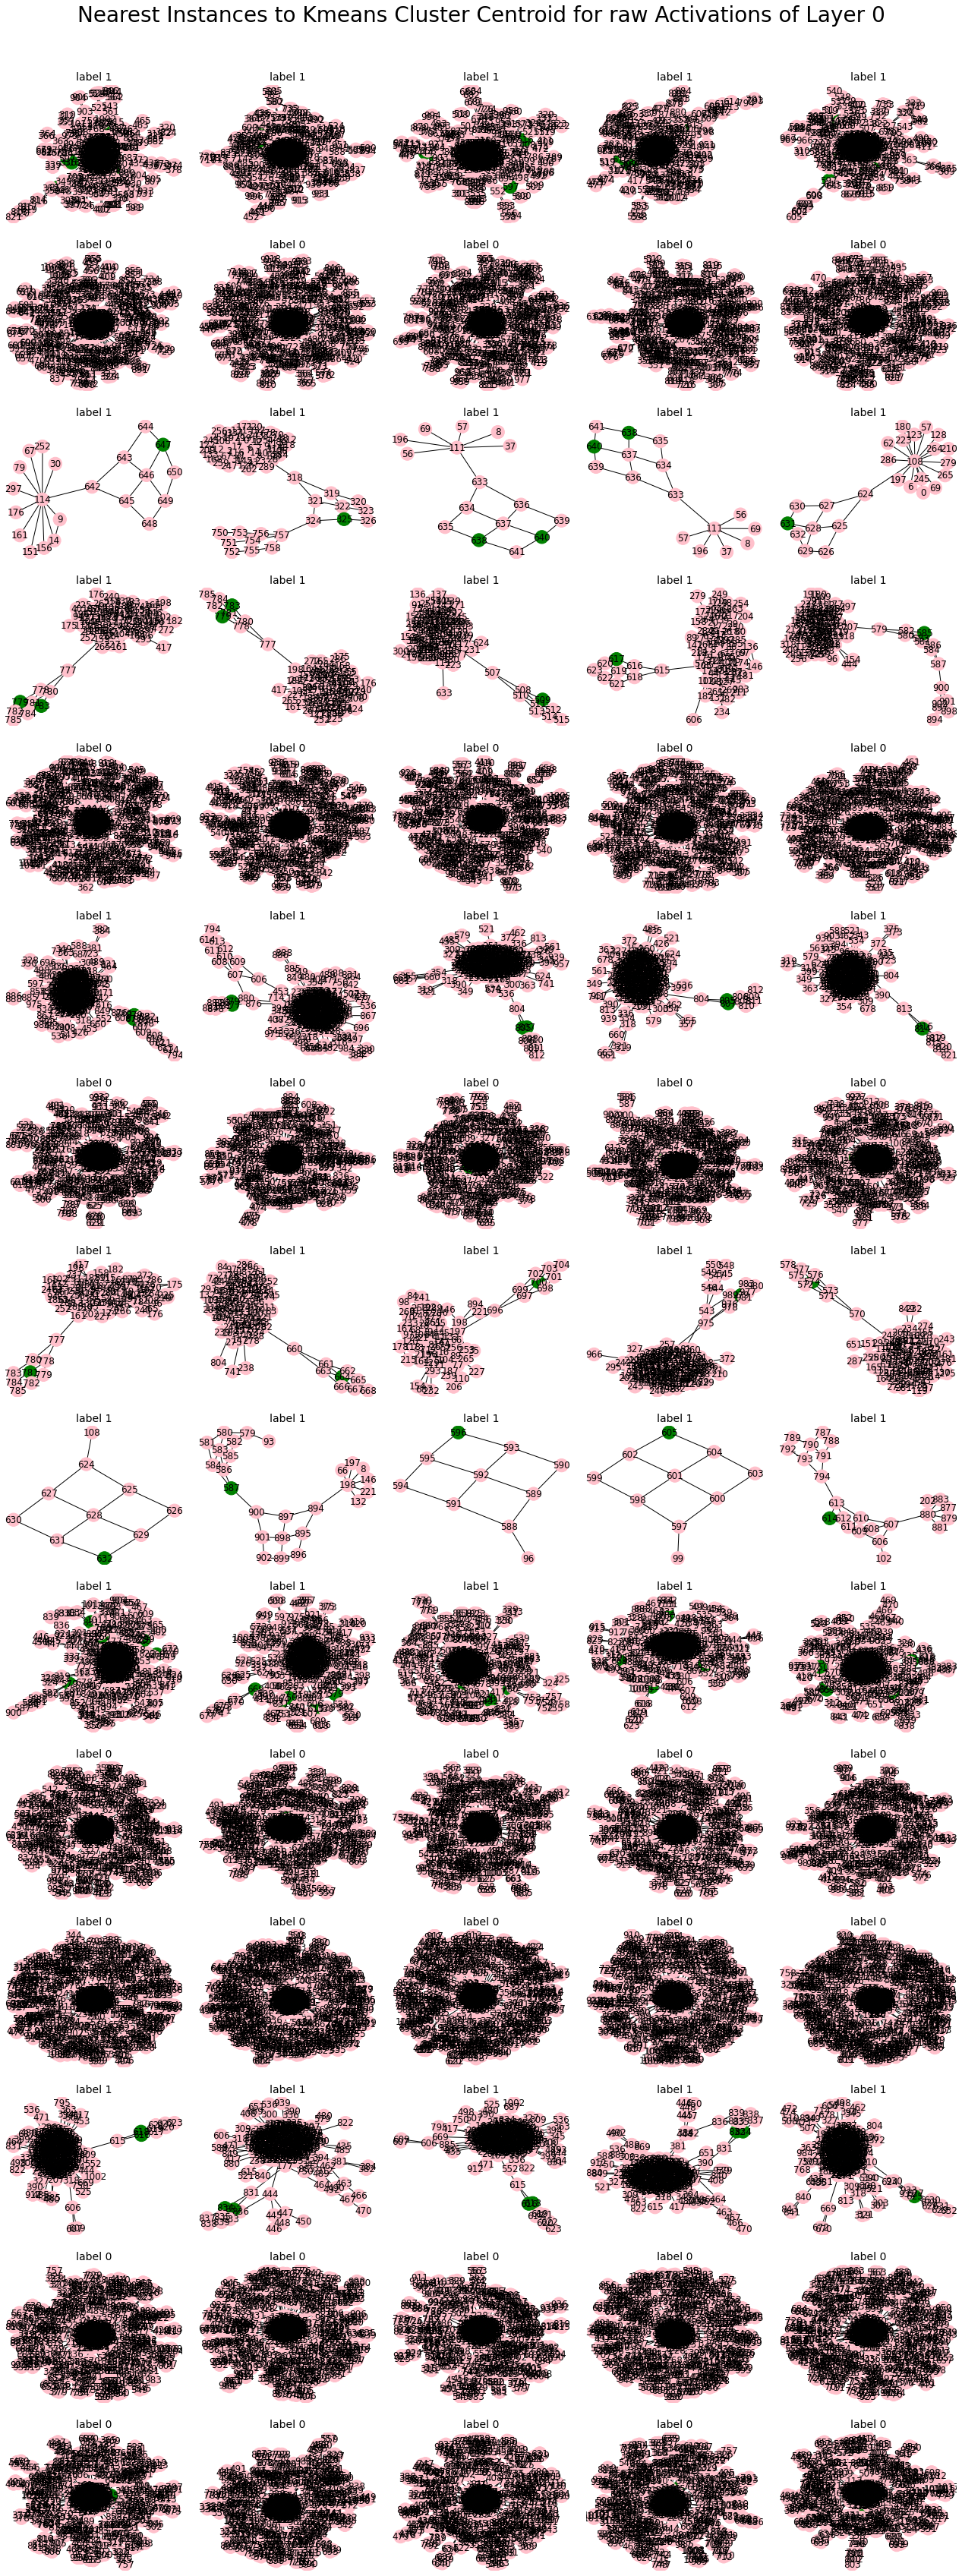

In [10]:

raw_kmeans_sample_feat = []
raw_kmeans_sample_graphs = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "Kmeans", "raw", num_nodes_view, edges, num_expansions, paths['KMeans'])

    raw_kmeans_sample_graphs.append(sample_graphs)
    raw_kmeans_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [11]:
# tsne_kmeans_sample_graphs = []
# tsne_kmeans_sample_feat = []
# tsne_kmeans_models = []
# for layer_num, item in enumerate(tsne_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     tsne_kmeans_sample_graphs.append(sample_graphs)
#     tsne_kmeans_sample_feat.append(sample_feat)
#     tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [12]:
# pca_kmeans_sample_graphs = []
# pca_kmeans_sample_feat = []
# pca_kmeans_models = []

# for layer_num, item in enumerate(pca_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "PCA reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     pca_kmeans_sample_graphs.append(sample_graphs)
#     pca_kmeans_sample_feat.append(sample_feat)
#     pca_kmeans_models.append(kmeans_model)

##### UMAP

In [13]:
# umap_kmeans_sample_graphs = []
# umap_kmeans_sample_feat = []
# umap_kmeans_models = []
# for layer_num, item in enumerate(umap_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     umap_kmeans_sample_graphs.append(sample_graphs)
#     umap_kmeans_sample_feat.append(sample_feat)
#     umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [14]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [15]:
# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [16]:
# raw_n_clusters = [28, 3, 9, 3, 5]

# raw_hc_sample_graphs = []
# raw_hc_sample_feat = []
# raw_hc_models = []
# for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(activation)

#     d = (activation, pred_labels)
#     plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "raw", num_nodes_view, edges, num_expansions, paths['Ward'])

#     raw_hc_sample_graphs.append(sample_graphs)
#     raw_hc_sample_feat.append(sample_feat)
#     raw_hc_models.append(hc)


##### TSNE

In [17]:
# for layer_num, item in enumerate(tsne_data):
#     plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [18]:
# tsne_n_clusters = [7, 12, 30, 30, 12]

# tsne_hc_sample_graphs = []
# tsne_hc_sample_feat = []
# tsne_hc_models = []
# for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

#     tsne_hc_sample_graphs.append(sample_graphs)
#     tsne_hc_sample_feat.append(sample_feat)
#     tsne_hc_models.append(hc)


##### PCA

In [19]:
# for layer_num, item in enumerate(pca_data):
#     plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [20]:
# pca_n_clusters = [4, 3, 9, 3, 5]

# pca_hc_sample_graphs = []
# pca_hc_sample_feat = []
# pca_hc_models = []
# for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "PCA reduced", num_nodes_view, edges, num_expansions, paths['HC'])

#     pca_hc_sample_graphs.append(sample_graphs)
#     pca_hc_sample_feat.append(sample_feat)
#     pca_hc_models.append(hc)

##### UMAP

In [21]:
# for layer_num, item in enumerate(umap_data):
#     plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [22]:
# umap_n_clusters = [9, 9, 18, 12, 23]

# umap_hc_sample_graphs = []
# umap_hc_sample_feat = []
# umap_hc_models = []
# for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

#     umap_hc_sample_graphs.append(sample_graphs)
#     umap_hc_sample_feat.append(sample_feat)
#     umap_hc_models.append(hc)

#### Heuristics

In [23]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [24]:
# # num_nodes_view = 5
# # num_expansions = 2
# # edges = data['edge_list'].numpy()

# esp = 0.5
# min_samples = 9

# raw_dbscan_sample_feats = []
# raw_dbscan_sample_graphs = []
# raw_dbscan_models = []
# raw_dbscan_ds = []
# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(activation)
#     pred_labels = dbscan_model.fit_predict(activation)

#     num_cluster = len(np.unique(pred_labels))
#     d = (activation, pred_labels)
#     raw_dbscan_ds.append(d)

#     plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     raw_dbscan_sample_graphs.append(sample_graphs)
#     raw_dbscan_sample_feats.append(sample_feat)
#     raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [25]:
# tsne_dbscan_sample_graphs = []
# tsne_dbscan_sample_feats = []
# tsne_dbscan_models = []
# tsne_dbscan_ds = []
# for layer_num, item in enumerate(tsne_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     tsne_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     tsne_dbscan_sample_graphs.append(sample_graphs)
#     tsne_dbscan_sample_feats.append(sample_feat)
#     tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [26]:
# pca_dbscan_sample_graphs = []
# pca_dbscan_sample_feats = []
# pca_dbscan_models = []
# pca_dbscan_ds = []

# for layer_num, item in enumerate(pca_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     pca_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     pca_dbscan_sample_graphs.append(sample_graphs)
#     pca_dbscan_sample_feats.append(sample_feat)
#     pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [27]:
# umap_dbscan_sample_graphs = []
# umap_dbscan_sample_feats = []
# umap_dbscan_models = []
# umap_dbscan_ds = []

# for layer_num, item in enumerate(umap_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     umap_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     umap_dbscan_sample_graphs.append(sample_graphs)
#     umap_dbscan_sample_feats.append(sample_feat)
#     umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [28]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

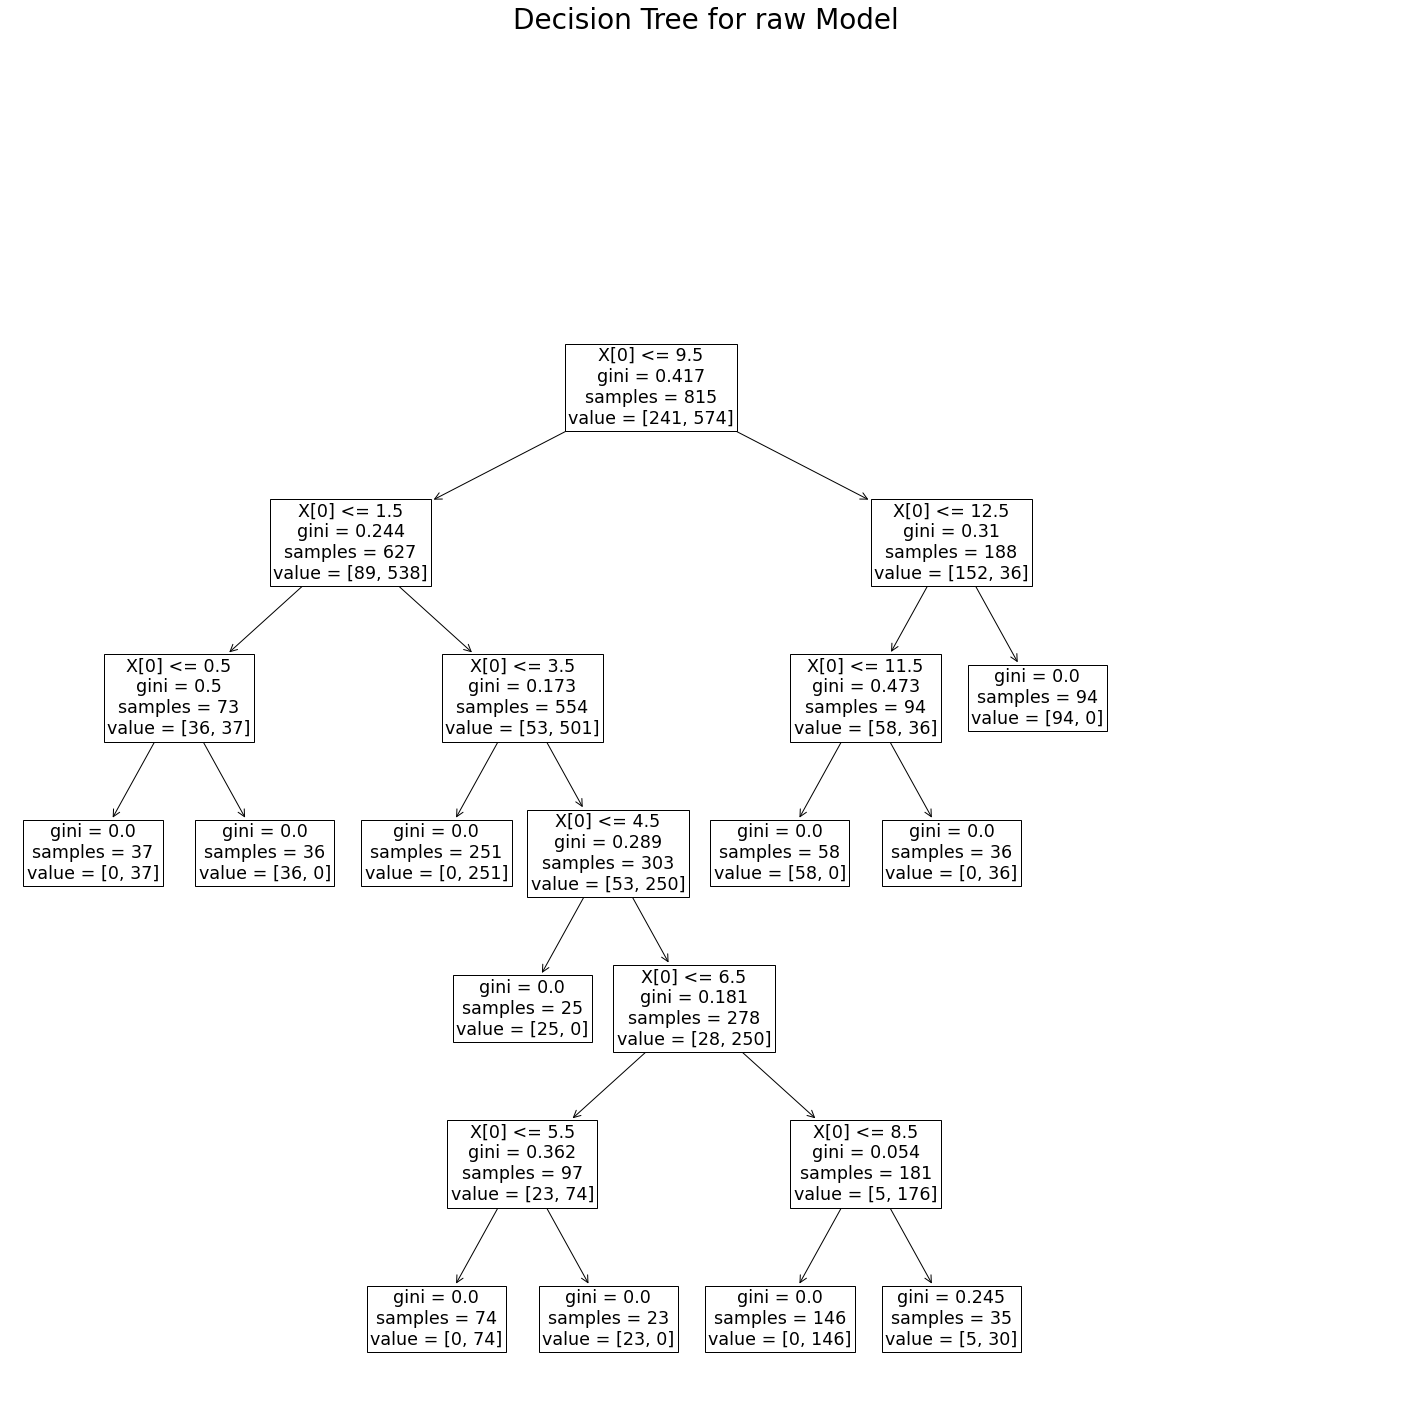

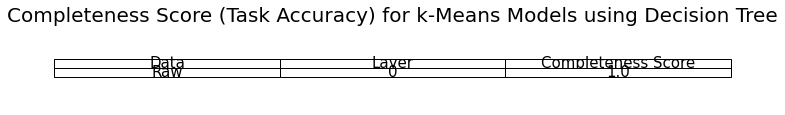

In [29]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

In [30]:
# # check training progress

# x = data["x"]
# edges = data["edges"]
# y = data["y"]
# train_mask = data["train_mask"]
# test_mask = data["test_mask"]
# print(test(model, x, y, edges, test_mask))

# activation = torch.squeeze(activation_list['conv2']).detach().numpy()
# kmeans_model = KMeans(n_clusters=9, random_state=0)
# kmeans_model = kmeans_model.fit(activation)

# testing = ActivationClassifier(activation, kmeans_model, classifier_str, data["x"], data["y"], data["x"], data["y"], data["edges"], i)
# print(testing.accuracy)


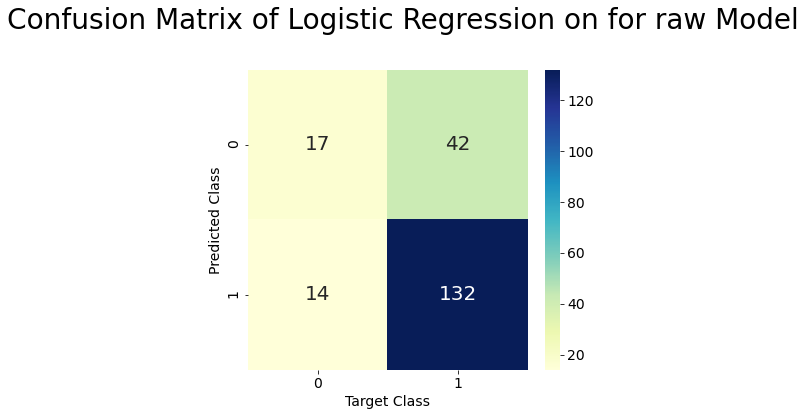

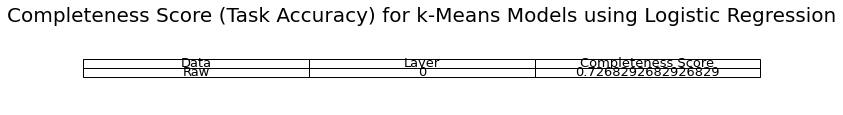

In [31]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")
    
# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")
    
plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])
    

### Using Hierarchical Clustering

##### Using Ward

In [32]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Decision Tree", completeness_scores, paths["Ward"])



In [33]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths["Ward"])
    

##### Using DBSCAN

In [34]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Decision Tree", completeness_scores, paths["DBSCAN"])


In [35]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Logistic Regression", completeness_scores, paths["DBSCAN"])
    

# Graph Similarity

In [36]:
##### KMeans

In [ ]:
graph_scores = []
view = 3
max_num_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, data['y'], i, k, "k-Means", "raw", view, edges, num_expansions, paths['KMeans'])
        
        
# for i, item in enumerate(tsne_data):    
#     distances = get_node_distances(tsne_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_kmeans_models[i], item, data['y'], i, k, "k-Means", "t-SNE", view, edges, num_expansions, paths['KMeans'])
    
# for i, item in enumerate(pca_data):
#     distances = get_node_distances(pca_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_kmeans_models[i], item, data['y'], i, k, "k-Means", "PCA", view, edges, num_expansions, paths['KMeans'])


# for i, item in enumerate(umap_data):
#     distances = get_node_distances(umap_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_kmeans_models[i], item, data['y'], i, k, "k-Means", "UMAP", view, edges, num_expansions, paths['KMeans'])
    
plot_graph_similarity_table("k-Means", graph_scores, paths['KMeans'])
    

Nodes  460  Graphs  3
skipping (too many nodes)
Nodes  654  Graphs  3
skipping (too many nodes)
Nodes  21  Graphs  3
skipping (too many nodes)
Nodes  117  Graphs  3
skipping (too many nodes)
Nodes  727  Graphs  3
skipping (too many nodes)
Nodes  371  Graphs  3
skipping (too many nodes)
Nodes  607  Graphs  3
skipping (too many nodes)
Nodes  117  Graphs  3
skipping (too many nodes)
Nodes  10  Graphs  3
skipping (too many nodes)
Nodes  487  Graphs  3
skipping (too many nodes)
Nodes  671  Graphs  3
skipping (too many nodes)
Nodes  796  Graphs  3
skipping (too many nodes)
Nodes  340  Graphs  3
skipping (too many nodes)
Nodes  696  Graphs  3
skipping (too many nodes)
Nodes  656  Graphs  3
skipping (too many nodes)


In [ ]:
# graph_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     pred_labels = raw_hc_models[i].fit_predict(activation)
#     d_item = (activation, pred_labels)
#     distances = get_node_distances(raw_hc_models[i], d_item)
    
#     for k_idx in range(n):        
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
                
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC", "raw", view, edges, num_expansions, paths['Ward'])
        
        
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
#     pred_labels = tsne_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(tsne_hc_models[i], d_item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC", "t-SNE", view, edges, num_expansions, paths['Ward'])
        

        
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     pred_labels = pca_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(pca_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC", "PCA", view, edges, num_expansions, paths['Ward'])
    

# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     pred_labels = umap_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(umap_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_hc_models[i], d_item, data["y"], i, n, "HC", "UMAP", view, edges, num_expansions, paths['Ward'])
        
    
# plot_graph_similarity_table("HC", graph_scores, paths['Ward'])
    

In [ ]:
# graph_scores = []
# view = 3
# max_num_nodes = 15

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, raw_dbscan_ds[i])

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
# #     plot_samples(dbscan_model, raw_dbscan_ds[i], data['y'], i, n, "DBSCAN", "raw", view, edges, num_expansions, paths['DBSCAN'])
        
# for i, item in enumerate(tsne_data):  
#     dbscan_model, n = tsne_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, tsne_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     print("New Line")
# #     plot_samples(dbscan_model, tsne_dbscan_ds[i], data['y'], i, n, "DBSCAN", "t-SNE", view, edges, num_expansions, paths['DBSCAN'])
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, pca_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     print("New Line")
# #     plot_samples(dbscan_model, pca_dbscan_ds[i], data['y'], i, n, "DBSCAN", "PCA", view, edges, num_expansions, paths['DBSCAN'])


# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, umap_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     print("New Line")
# #     plot_samples(dbscan_model, umap_dbscan_ds[i], data['y'], i, n, "DBSCAN", "UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
# plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [ ]:
node_idx = 389

In [ ]:
# Explain using k-Means
edges = data['edge_list'].numpy()

# get predicted cluster label - visualise top representations in cluster
activation_key = 'conv3'
layer_idx = 0

# get concept number
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
concepts = raw_kmeans_models[layer_idx].predict(activations) 

# get top example for concept/cluster
concept = concepts[node_idx]
top_graph = raw_kmeans_sample_graphs[layer_idx][concept][0]
color_map = raw_kmeans_sample_feat[layer_idx][concept]

fig, ax = plt.subplots()
nx.draw(top_graph, node_color=color_map, with_labels=True, ax=ax)
ax.set_title(f"Top Example of Concept extracted using k-Means for Node {node_idx}")
plt.show()

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using k-Means for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # node_idx = 698

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 'linear'
# layer_idx = 4
# n = 5

# # get top surrouning examples
# activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
# hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
# concepts = hc.fit_predict(activations)

# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels, _ = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle(f"Top Example of Concept extracted using HC for Node {node_idx}")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(hc, d, data['y'], edges, concept, num_expansions)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle(f"Nearest Concept representations extacted using HC for Node {node_idx}")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # convert to edge format
# edges = data['edges'].t().contiguous()

# explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], data['edges'])

# ax, G = explainer.visualize_subgraph(node_idx, data['edges'], edge_mask, y=data['y'], threshold=0.8)
# plt.title(f"GNNExplainer explanation for Node {node_idx}")
# plt.axis('off')
# plt.show()